# Final Project

This notebook uses breast cancer diagnostic data [made available by UCI Machine Learning on Kaggle](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data) to train a model to determine whether or not a mass is benign or malignant. A Random Forest was selected as the classification model, and it was analyzed with different numbers of trees, maximum depths, and parameter selection methods. The final chosen model was a Random Forest with 250 trees, a maximum depth of 10 nodes, and a logarithmic selection of parameters for each tree. This model yielded an accuracy of 0.920 on the test data.

### Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
sns.set()

### Data Import

The dataset used for this model is the result of imaging performed on the cell nucleus of a suspected cancerous mass obtained from a patient's breast tissue. For each nucleus, the following values were measured:
- `Radius`
- `Perimeter`
- `Area`
- `Texture`
- `Smoothness`
- `Compactness`
- `Concavity`
- `Concave Points`
- `Symmetry`
- `Fractal Dimension`

For each measure, the mean, standard error, and worst (or highest) value were recorded in the dataset, along with a final diagnosis, `M` for malignant and `B` for benign.

The different variables were grouped by mean, SE, and worst, and their correlations were visualized below.

In [2]:
df = pd.read_csv('data.csv')

print(df.head())

means = df.get(['radius_mean', 'perimeter_mean', 'area_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean'])
ses = df.get(['radius_se', 'perimeter_se', 'area_se', 'texture_se', 'smoothness_se','compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se'])
worsts = df.get(['radius_worst', 'perimeter_worst', 'area_worst', 'texture_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'])


         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness

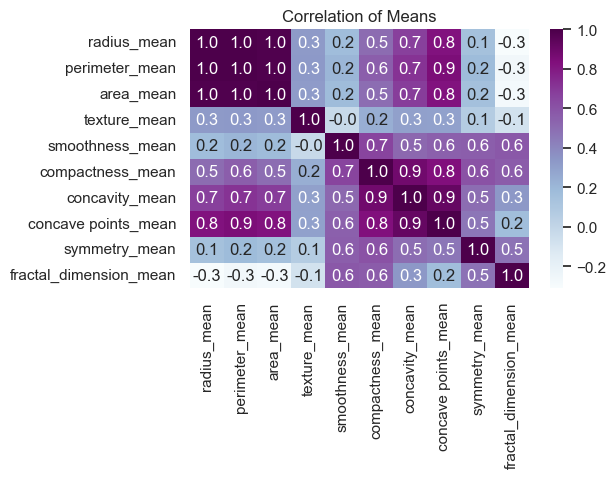

<Figure size 640x480 with 0 Axes>

In [3]:
sns.heatmap(means.corr(), annot=True, fmt='0.1f', cmap='BuPu')
plt.tight_layout()
plt.title(label='Correlation of Means')
plt.savefig('means_heatmap.png')
plt.show()
plt.clf()

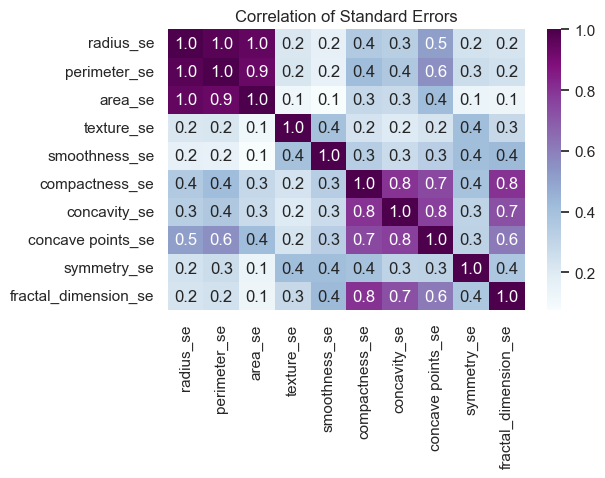

<Figure size 640x480 with 0 Axes>

In [4]:
sns.heatmap(ses.corr(), annot=True, fmt='0.1f', cmap='BuPu')
plt.tight_layout()
plt.title(label='Correlation of Standard Errors')
plt.savefig('ses_heatmap.png')
plt.show()
plt.clf()

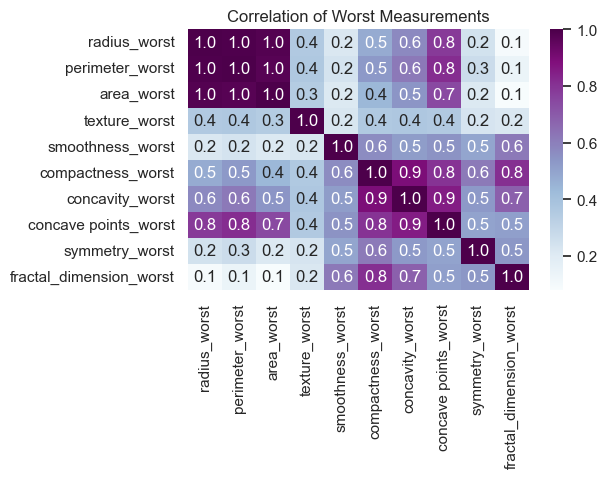

<Figure size 640x480 with 0 Axes>

In [5]:
sns.heatmap(worsts.corr(), annot=True, fmt='0.1f', cmap='BuPu')
plt.tight_layout()
plt.title(label='Correlation of Worst Measurements')
plt.savefig('worsts_heatmap.png')
plt.show()
plt.clf()

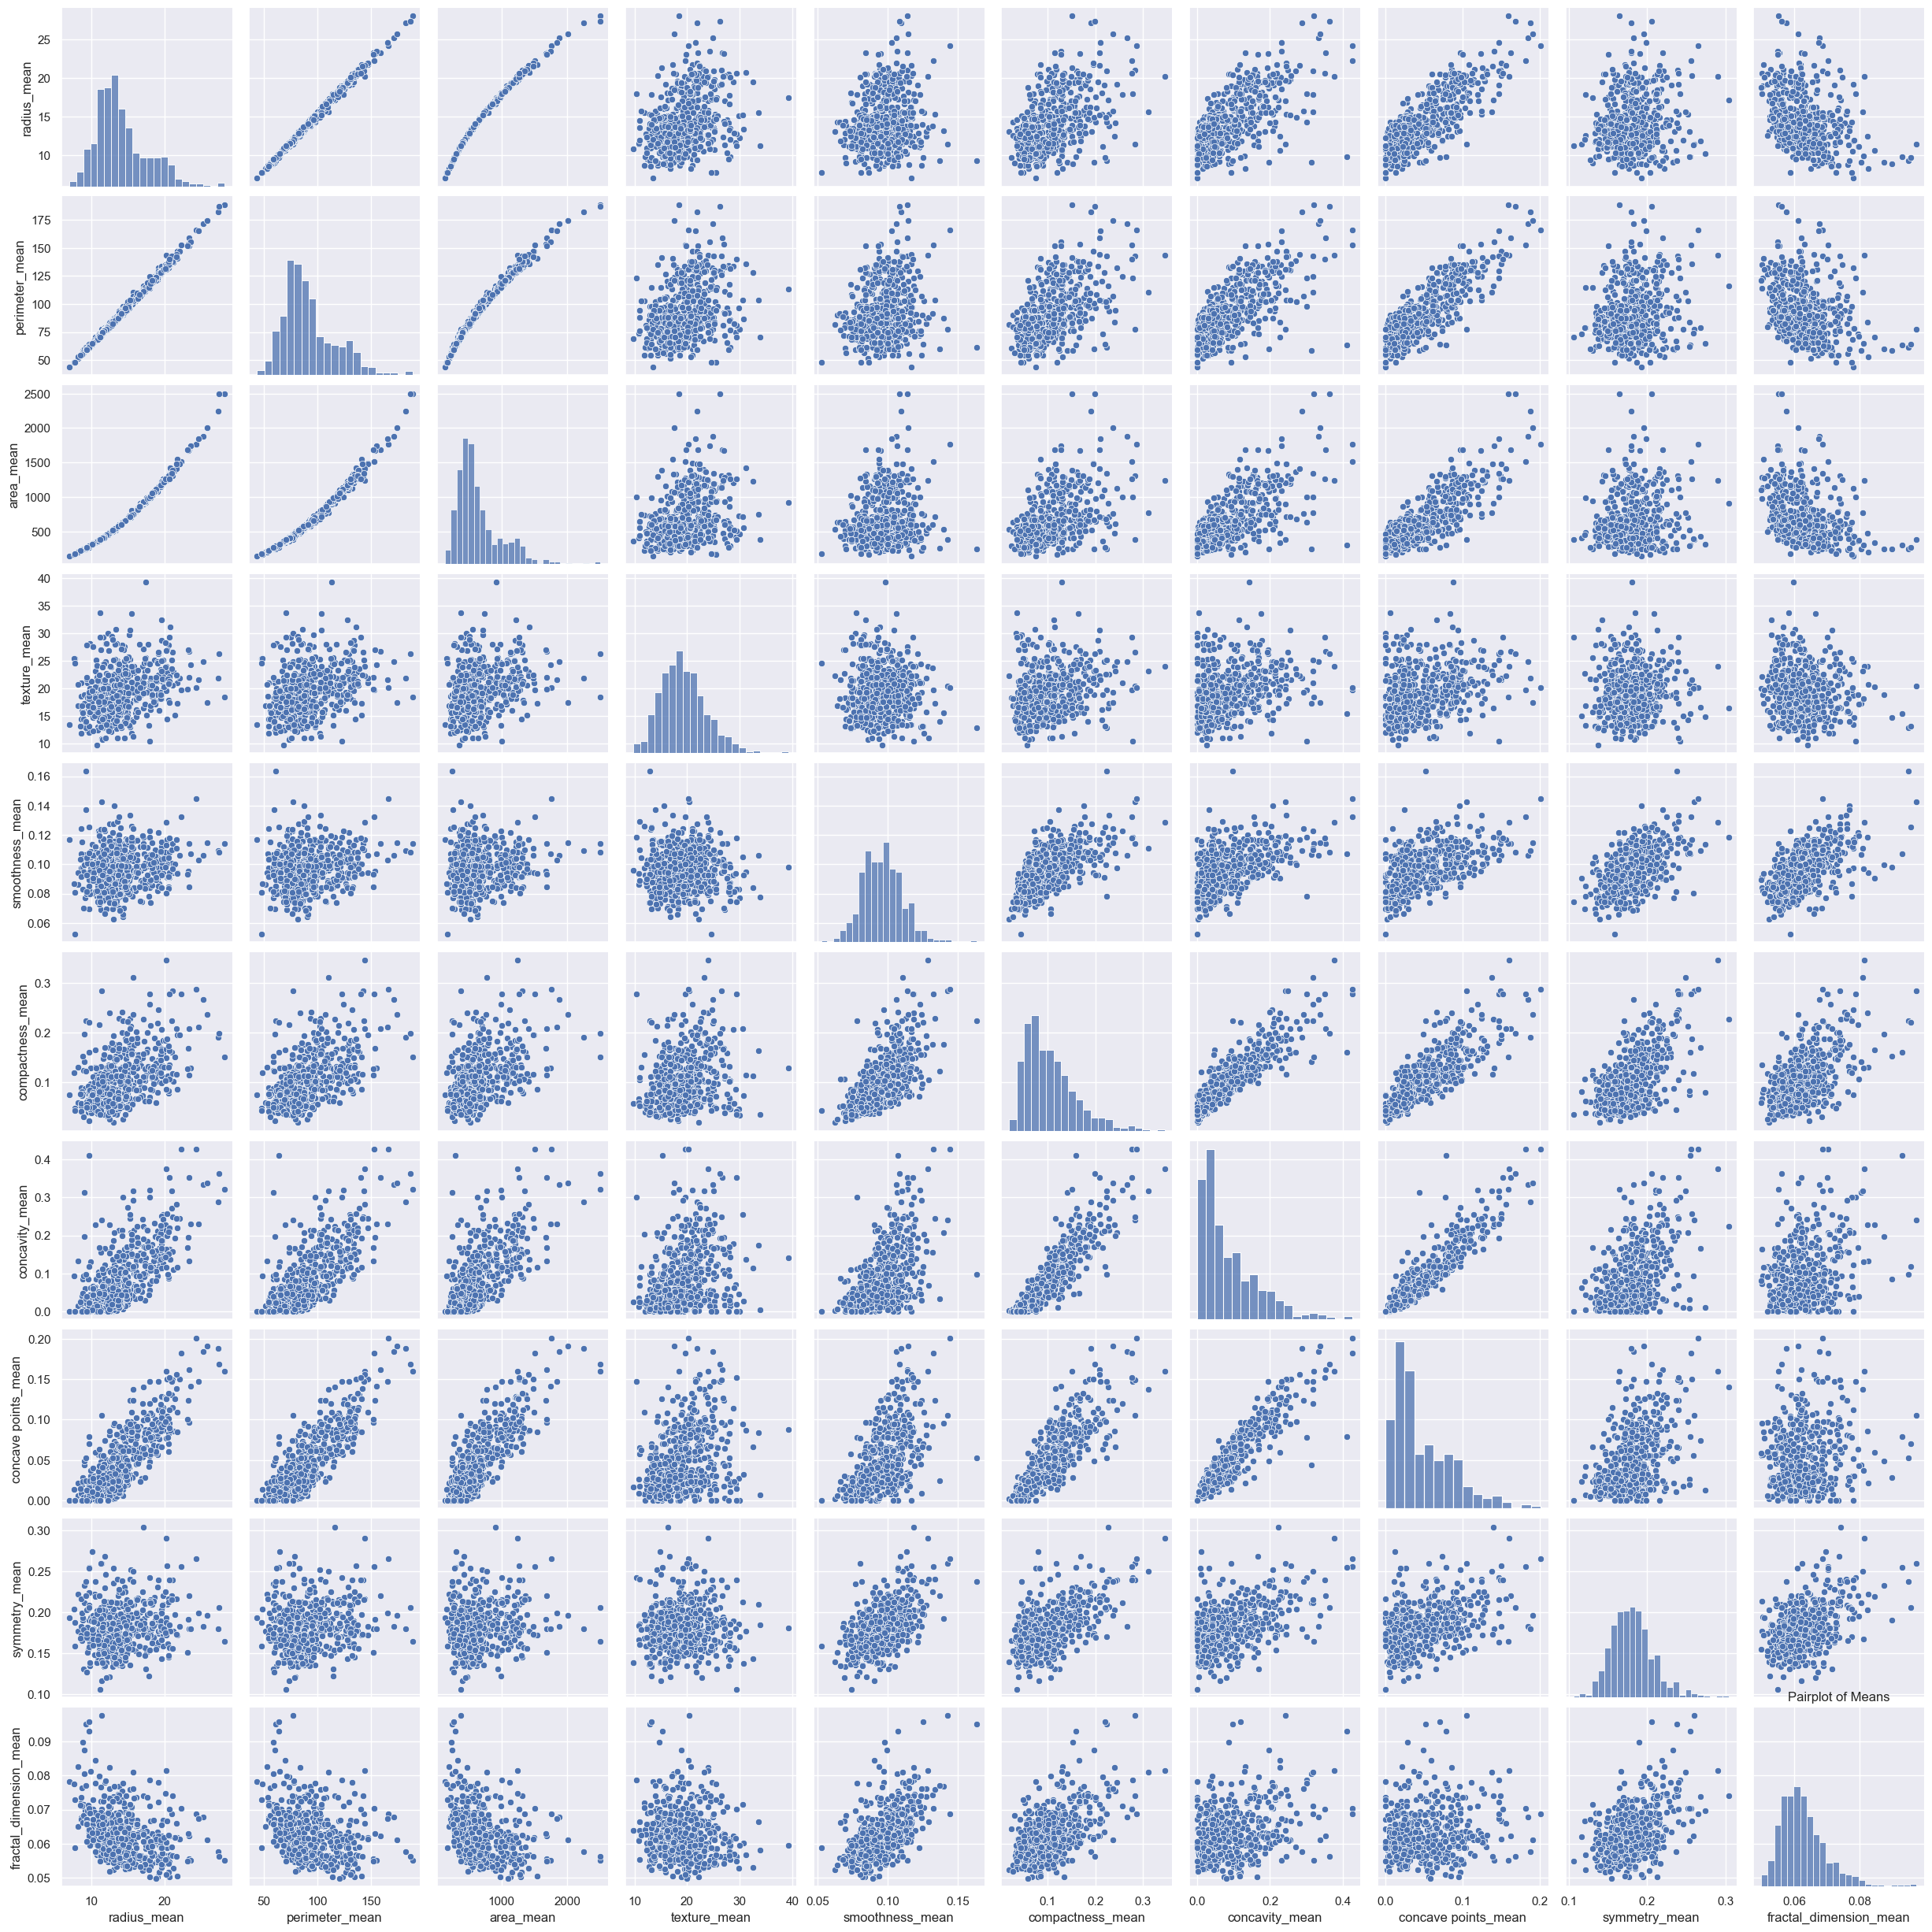

<Figure size 640x480 with 0 Axes>

In [6]:
sns.pairplot(means)
plt.title(label='Pairplot of Means')
plt.savefig('means_pairplot.png')
plt.show()
plt.clf()

### Model Selection

As shown in the visualizations above, there is significant correlation among some of the features in the dataset. Most notably, the radius, perimeter, and area measures are highly correlated, which makes logical sense as they are all measures of the size of the nucleus. Additionally, the compactness, concavity, and concave points measures are also highly correlated, as they are all measures of the shape of the nucleus. Because of the high degree of correlation among the variables, a Random Forest model was chosen as a means of 'de-correlating' the model, and allowing some features to be used when they otherwise may have been ignored.

In [7]:
class RandomForest():
    
    def __init__(self, x, y, sample_sz, n_trees=200, n_features='sqrt', max_depth=10, min_samples_leaf=5):
        """
        Create a new random forest classifier.
        
        Args:
            x : Input Feature vector
            y : Corresponding Labels
            sample_sz : Sample size
            n_trees : Number of trees to ensemble
            n_features : Method to select subset of features 
            max_depth : Maximum depth of the trees in the ensemble
            min_sample_leaf : Minimum number of samples per leaf 
        """
        np.random.seed(42)
        if n_features == 'sqrt':
            self.n_features = int(np.sqrt(x.shape[1]))
        elif n_features == 'log2':
            self.n_features = int(np.log2(x.shape[1]))
        else:
            self.n_features = n_features
        self.features_set = []
        self.x, self.y, self.sample_sz, self.max_depth, self.min_samples_leaf  = x, y, sample_sz, max_depth, min_samples_leaf
        self.trees = [self.create_tree(i) for i in range(n_trees)]

    def create_tree(self,i):
        """
        create a single decision tree classifier
        """
        
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        idxs = np.asarray(idxs)

        f_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        f_idxs = np.asarray(f_idxs)
        
        if i==0:
            self.features_set = np.array(f_idxs, ndmin=2)
        else:
            self.features_set = np.append(self.features_set, np.array(f_idxs,ndmin=2),axis=0)

        y = np.take(self.y, idxs)
        x = self.x[idxs]
        z = np.array([np.array(f[f_idxs]) for f in x])
        clf = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf).fit(z, y)
        return clf

    def individual_predict(self, x):
        self.tree_predictions = np.zeros([len(self.trees),len(x)])
        for i in range(len(x)):
            current_obs = x[i]
            cur_obs_pred = []
            for j in range(len(self.features_set)):
                features = self.features_set[j]
                x_curr = current_obs[features]
                clf = self.trees[j]
                #print(x_curr.reshape(1,-1))
                pred = clf.predict(x_curr.reshape(1,-1))
                #print(pred[0])
                #print(self.tree_predictions[j])
                #print('----------------------------------')
                self.tree_predictions[j][i] = pred[0]
       
    def predict(self, x, num_trees = None):
        if num_trees == None:
            num_trees = len(self.trees)
        predictions = []

        individual_predictions = self.tree_predictions[0:num_trees]
        
        for i in range(len(x)):
            cur_obs_pred = [tree_pred[i] for tree_pred in individual_predictions]
            values, counts = np.unique(cur_obs_pred, return_counts=True)

            predicted = np.argmax(counts)
            if predicted == 0:
                predicted = -1
            predictions.append(predicted)

        return predictions
    
    def score(self, X, y, num_trees = None):
        if num_trees == None:
            num_trees = len(self.trees)
        self.correct_counts = np.zeros(len(self.trees))
        correct = 0
        predictions = self.predict(X, num_trees)
        for i in range(len(y)):
            if predictions[i] == y[i]:
                correct += 1
            for j in range(num_trees):
                if self.tree_predictions[j][i] == y[i]:
                    self.correct_counts[j] += 1
                
        self.accuracy_ratings = self.correct_counts / len(y)
        return correct / len(y)


    def get_best_trees(self, n=1):
        indices = np.argsort(self.accuracy_ratings)[-n:]

        return np.array(self.trees)[indices], np.array(self.features_set)[indices], np.array(self.accuracy_ratings)[indices]

    def print_best_trees(self, n, feature_names):
        trees, features_set, ratings = self.get_best_trees(n)
        for i in range(len(trees)):
            names = np.array(feature_names)[features_set[i]]
            clf = trees[i]
            plt.figure(figsize=(14,14))
            tree.plot_tree(clf, feature_names=names, class_names=['Malignant', 'Benign'], filled=True, rounded=True)
            plt.title(label=f'Tree with accuracy {ratings[i]:.3f}')
            plt.savefig(f'tree_{n - i}.png')
            plt.show()

In [8]:
y_true = np.array([-1 if val == 'M' else 1 for val in df['diagnosis']])
df_cleaned = df.drop(columns=['id', 'diagnosis', 'Unnamed: 32'])


X_train, X_test, y_train, y_test = train_test_split(df_cleaned.to_numpy(), y_true, test_size=0.33, random_state=42)

total_trees = 250

clf_d3 = RandomForest(X_train, y_train, 300, n_trees = total_trees, max_depth=3)
clf_d3.individual_predict(X_test)
scores_d3 = [0]
for i in range(1, total_trees + 1):
	scores_d3.append(clf_d3.score(X_test, y_test, num_trees=i))

clf_d5 = RandomForest(X_train, y_train, 300, n_trees = total_trees, max_depth=5)
clf_d5.individual_predict(X_test)
scores_d5 = [0]
for i in range(1, total_trees + 1):
	scores_d5.append(clf_d5.score(X_test, y_test, num_trees=i))

clf_d10 = RandomForest(X_train, y_train, 300, n_trees = total_trees, max_depth=10)
clf_d10.individual_predict(X_test)
scores_d10 = [0]
for i in range(1, total_trees + 1):
	scores_d10.append(clf_d10.score(X_test, y_test, num_trees=i))

clf_d10_log2 = RandomForest(X_train, y_train, 300, n_trees = total_trees, max_depth=10, n_features='log2')
clf_d10_log2.individual_predict(X_test)
scores_d10_log2 = [0]
for i in range(1, total_trees + 1):
	scores_d10_log2.append(clf_d10_log2.score(X_test, y_test, num_trees=i))




### Model Comparison

The cell below plots the accuracy of each of the models as they grow in size. After a count of approximately 50 trees, the logarithmic model with a max depth of 10 nodes begins to show signs of being the most accurate, which continues to be the case from then onward. Interestingly, most of the models show a sizeable jump in accuracy just before reaching a size of 100 trees. The Depth 3 model appeared to plateau quite early on, before improving in accuracy again around the 100 tree mark.

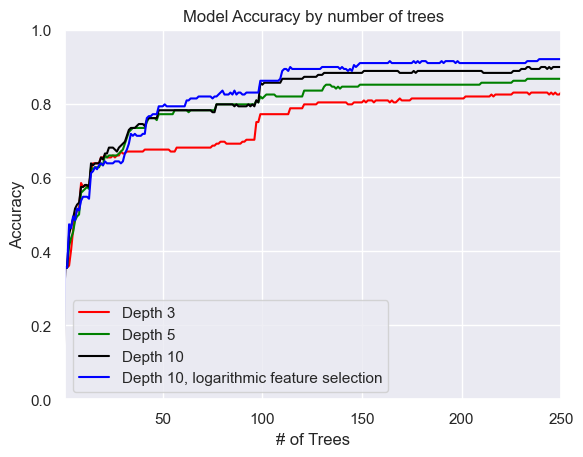

<Figure size 640x480 with 0 Axes>

In [9]:
plt.plot(scores_d3, color='red')
plt.plot(scores_d5, color='green')
plt.plot(scores_d10, color='black')
plt.plot(scores_d10_log2, color='blue')
plt.xlabel('# of Trees')
plt.ylabel('Accuracy')
plt.axis([1, total_trees, 0, 1])
plt.legend(['Depth 3', 'Depth 5', 'Depth 10', 'Depth 10, logarithmic feature selection'])
plt.title(label='Model Accuracy by number of trees')
plt.savefig('tree_accuracy.png')
plt.show()
plt.clf()

In [10]:
score = clf_d10_log2.score(X_test, y_test)
pred_score = 1 - score
print('Misclassification error on test data : %0.3f'%pred_score)
print('Accuracy on test data: %0.3f'%score)

Misclassification error on test data : 0.080
Accuracy on test data: 0.920


### Visualization

Because a Random Forest does not provide a single decision tree from which to gain insight, it is not always optimal for analyses where a 'flowchart' style tree might be useful, such as the case of determining a cancer diagnosis. In order to circumvent this issue, a modification was made to the `RandomForest` base class, so that each tree within the model could be scored individually against the test data. After testing was completed, the most accurate trees could be accessed for further analysis/display. The three most accurate trees are shown below. Upon analyzing the three trees, it became apparent that `radius_worst` was one of the strongest predictors for whether a tumor was benign or malignant. Not only was it the feature at the root of all three trees, it also featured heavily within each tree at lower levels. 

An intersting topic for future discovery would be whether one could access only the most accurate trees for use with additional training data, to determine whether those trees are truly better, or if they simply happen to be a better fit for the existing training data. Conversely, the nature of feature selection in a random forest could have caused a significant number of trees to ignore what may have truly been the single best predictor. 

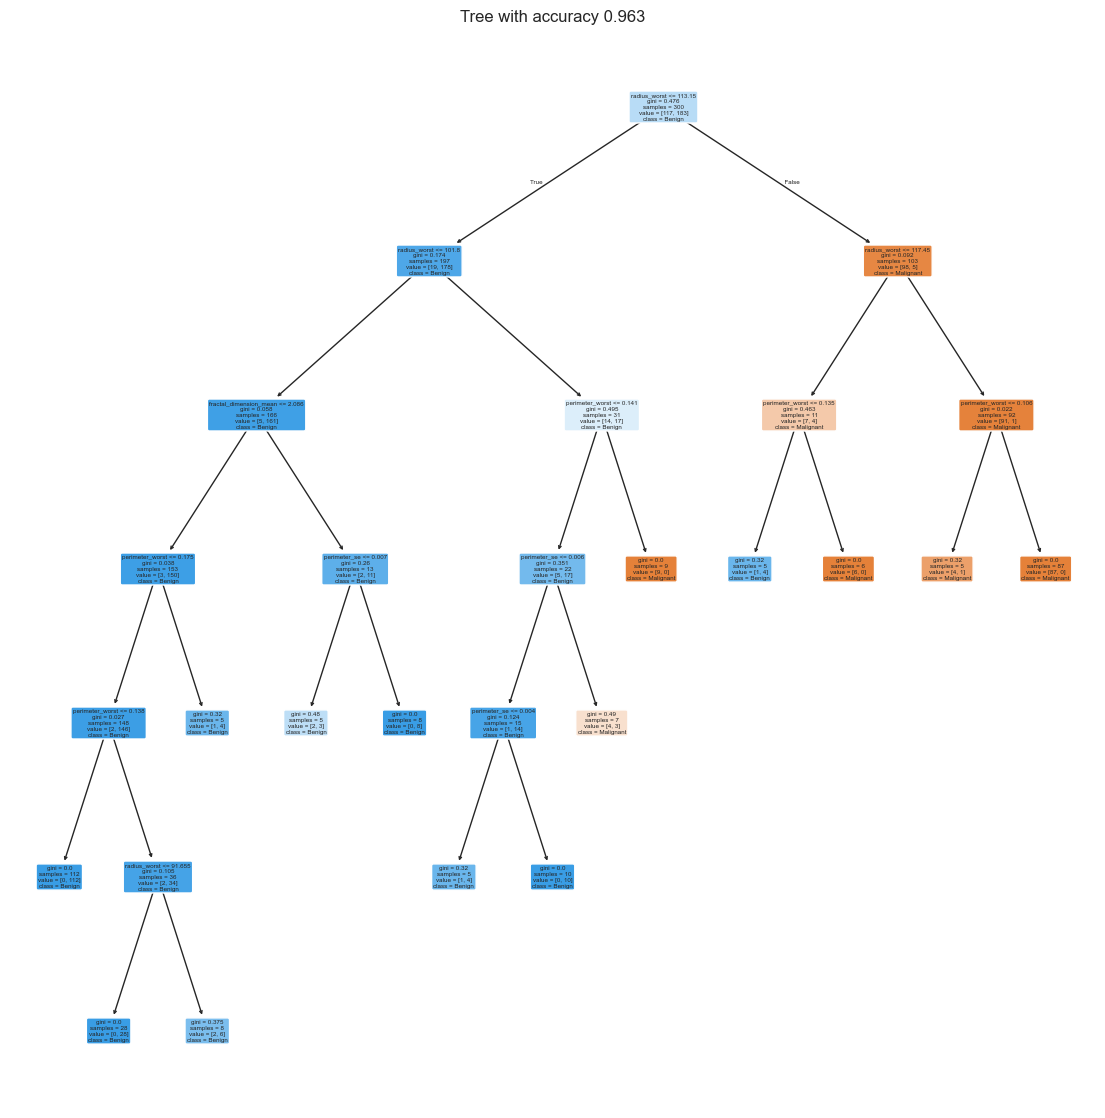

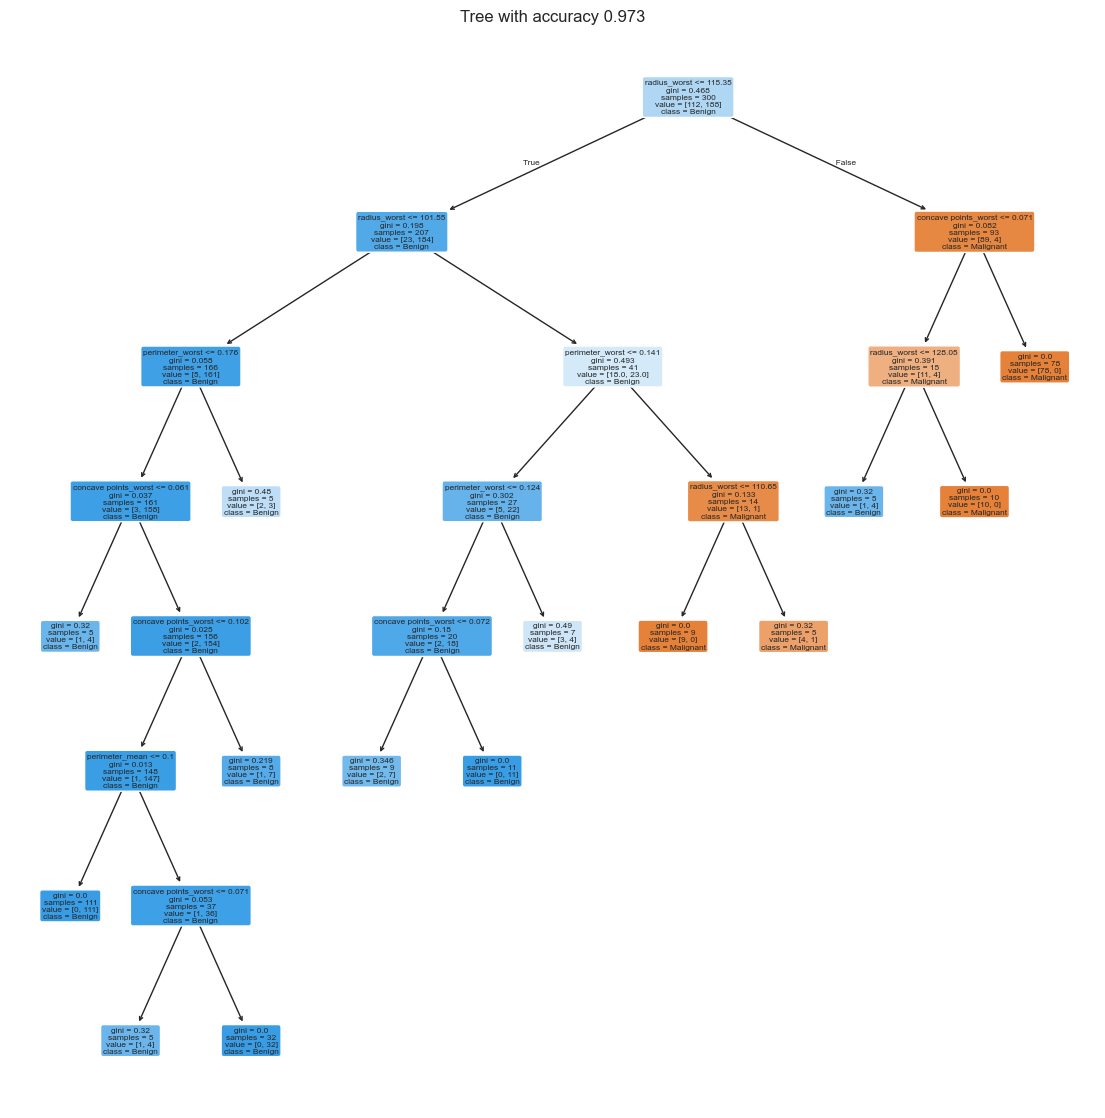

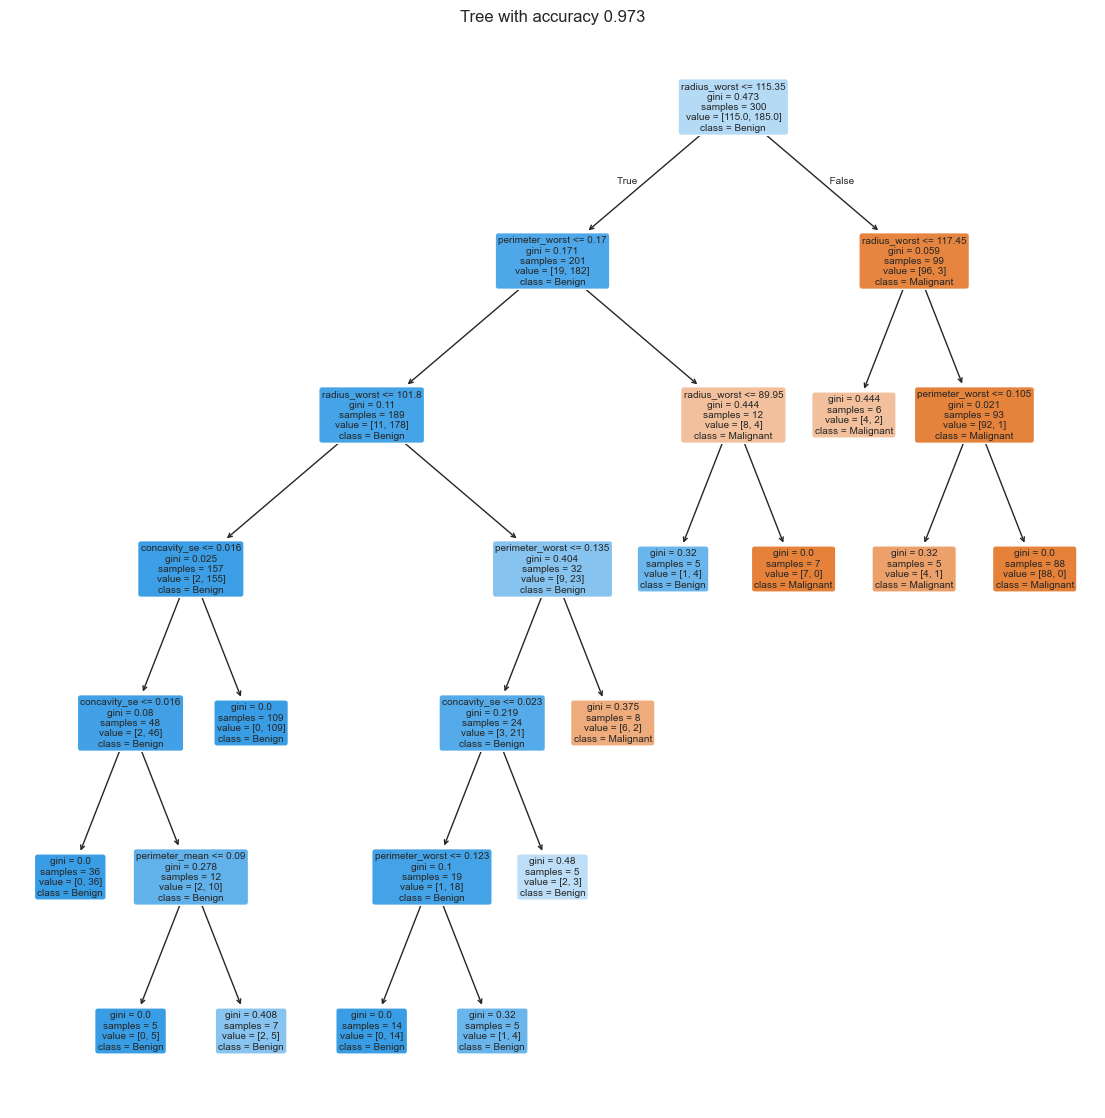

In [11]:
clf_d10_log2.print_best_trees(3, df.columns.values)